In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
import shap
from sklearn.model_selection import train_test_split
from utils.load_config_file import load_config_file

In [2]:
## Load Pre-Conversion MA data with Post-Conversion LTV Values
ma_data_o = pd.read_csv("data/with_zcta/ma_ltv_merged.csv", low_memory=False)
ma_data_o.head()

,application_id,owner_email,application_name,policy_id,owner_id,owner_phone,app_zip_code,pol_zip_code,parent_application_id,sk_referral_flag,...,tu_SUB_USER_ID,tu_GROUP_ID,tu_ACCOUNT,tu_CONTACT_SCORE,tu_CREDIT_SCORE,post_raw_application_id,post_raw_model_predicted_duration,LTV,post_raw_medicare_number,post_raw_policy_id
0,0001b60b-18da-471e-a8d8-8f9ddc79951e,NaN,Wellcare Dual Access (HMO D-SNP),21157188-444-124-000,2nu8wn0gm33,8.504662e+09,32507.0,NaN,0001b60b-18da-471e-a8d8-8f9ddc79951e,0,...,NaN,NaN,NaN,NaN,NaN,0001b60b-18da-471e-a8d8-8f9ddc79951e,15.0,996.250000,2NU8WN0GM33,21157188-444-124-000
1,00042fc5-f3cf-4c54-b746-41c77dbe51db,NaN,HumanaChoice H5216-248 (PPO),00013228007K_PPO,1dr1xm2ke15,5.409600e+09,24422.0,NaN,00042fc5-f3cf-4c54-b746-41c77dbe51db,0,...,5349.0,pickup,5349.0,42.0,556.0,NaN,NaN,NaN,NaN,NaN
2,0006a78d-2b0f-44e4-a1cb-e1f5a3416ff9,richard_kelly2007@yahoo.com,AARP Medicare Advantage Plan 2 (HMO),OEC_SFTCF04JQ36A0,1rj6fq6nh72,9.412650e+09,34221.0,NaN,0006a78d-2b0f-44e4-a1cb-e1f5a3416ff9,0,...,NaN,NaN,NaN,NaN,NaN,0006a78d-2b0f-44e4-a1cb-e1f5a3416ff9,19.0,946.083333,1RJ6FQ6NH72,OEC_SFTCF04JQ36A0
3,000b17c2-9ddc-45b8-818a-6dad511fe5de,clindabrown225@gmail.com,Humana Gold Plus H1951-048 (HMO),NaN,6y25k28gu56,2.252537e+09,70737.0,NaN,000b17c2-9ddc-45b8-818a-6dad511fe5de,0,...,5349.0,pickup,5349.0,239.0,490.0,NaN,NaN,NaN,NaN,NaN
4,000c6270-f162-4f5f-a0bb-104ccdb5274a,012345@noreply.com,Humana Gold Plus H0028-029 (HMO),00018705403K_HMO,8gf3jg1da73,3.613193e+09,78102.0,NaN,000c6270-f162-4f5f-a0bb-104ccdb5274a,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# replace Null values with 0 for numeric columns and N/A for categorical
ma_data = ma_data_o.copy()
categorical_columns = []
numeric_columns = []
for col in ma_data.columns:
        if ma_data[col].dtype in ['i', 'f', int, float]:
            numeric_columns.append(col)
            ma_data[col].fillna(0, inplace= True)
        elif ma_data[col].dtype in ['O', 'S', 'a']:
            categorical_columns.append(col)
            ma_data[col].fillna('N/A', inplace= True)
        else:
            ma_data[col].fillna('N/A', inplace= True)

numeric_columns.remove("post_raw_LTV calculated") # Target Variable

In [134]:
## Check the best predicted Carriers
df = ma_data_o.groupby(by="carrier").agg({'mod_LTV': np.mean})
df.sort_values(by='mod_LTV', ascending=False)

,mod_LTV
carrier,
O65 - United Health Care,620.900712
O65 - Cigna,619.385882
O65 - Wellcare,614.350131
O65 - Humana,512.965106
O65 - Anthem,416.451718
O65 - Allwell,342.905983
O65 - Priority Health,333.530572
O65 - Aetna,56.544597
O65 - Centene Corporation,0.000000


<AxesSubplot:xlabel='carrier'>

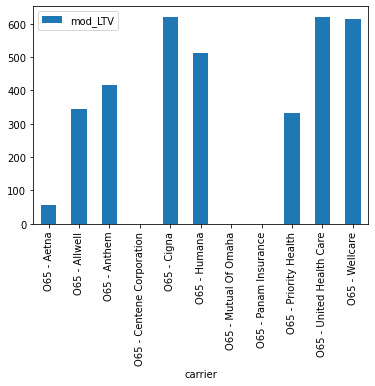

In [135]:
df.plot.bar()

In [3]:
## Post-process the Dataset
from utils.post_processing_utils import process_catboost

X_train, X_test = process_catboost(data=ma_data_o, config_path="config/config.ini", for_training=False, save_csv= True)

In [4]:
X_train

,submitted_weekday,submitted_day,submitted_month,submitted_year,area_code,age,age_range,jrn_boberdoo_amount,jrn_boberdoo_source,jrn_boberdoo_lead_type,...,tu_DEMO_OCCUPATION_FIRST,tu_STATUS_COUNT,tu_STATUS_LATENCY,tu_CONTACT_SCORE,tu_CREDIT_SCORE,zip_code,state,city,gender,LTV
3451,2,1,12,2021,617.0,59,Less than 65,NaN,NaN,NaN,...,NaN,17.0,0.332241,901.0,525.0,2155.0,MA,MEDFORD,F,1034.833333
4279,0,15,11,2021,816.0,27,Less than 65,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64155.0,MO,NaN,F,996.250000
19864,0,10,1,2022,423.0,69,65 to 75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37841.0,TN,NaN,F,946.083333
1557,0,1,3,2021,754.0,68,65 to 75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32305.0,FL,NaN,NaN,NaN
10992,1,25,1,2022,317.0,88,More than 85,NaN,NaN,NaN,...,NaN,16.0,0.312551,653.0,814.0,46280.0,IN,CARMEL,M,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1,7,12,2021,863.0,86,More than 85,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,33823.0,FL,NaN,M,NaN
11964,2,24,11,2021,205.0,64,Less than 65,NaN,NaN,NaN,...,whitecollar,17.0,0.331868,736.0,416.0,35045.0,AL,CLANTON,F,1017.333333
5390,5,19,2,2022,256.0,66,65 to 75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,35603.0,AL,NaN,F,946.083333
860,1,4,5,2021,618.0,80,75 to 85,NaN,NaN,NaN,...,NaN,10.0,0.332480,546.0,620.0,62203.0,IL,EAST SAINT LOUIS,F,NaN


In [49]:
X_train = pd.read_csv("models_py/data/ma_ltv_train.csv", low_memory=False)
X_test = pd.read_csv("models_py/data/ma_ltv_test.csv", low_memory=False)

# determine categorical and numerical features
numerical_cols = list(X_train.select_dtypes(include=["int64", "float64"]).columns)
print("numerical_cols:", len(numerical_cols))
categorical_cols = list(
        X_train.select_dtypes(include=["object", "string", "bool"]).columns
)
print("categorical_cols:", len(categorical_cols))


numerical_cols: 134
categorical_cols: 10


In [50]:
categorical_cols

['age_range',
 'jrn_boberdoo_source',
 'jrn_boberdoo_lead_type',
 'jrn_firstparty',
 'jrn_response_audit_token',
 'zcta_cms_mapd_mrkt_leader',
 'tu_DEMO_OCCUPATION_FIRST',
 'state',
 'city',
 'gender']

In [51]:
config = load_config_file(config_path="config/config.ini")
force_categorical = config["force_categorical"]
feats = []
for cat in force_categorical:
    feats = feats + [col for col in X_train.columns if cat in col]
print(feats)

['zip_code', 'submitted_weekday', 'submitted_day', 'jrn_day', 'jrn_response_audit_consumer_twelve_consumer_day', 'jrn_response_audit_device_day', 'jrn_response_audit_ip_day', 'jrn_response_audit_lead_day', 'submitted_year', 'jrn_year']


In [52]:
for f in feats:
    if f not in categorical_cols:
        categorical_cols.append(f)
    if f in numerical_cols:
        numerical_cols.remove(f)

print("numerical_cols:", len(numerical_cols))
print("categorical_cols:", len(categorical_cols))


numerical_cols: 124
categorical_cols: 20


In [53]:
categorical_cols

['age_range',
 'jrn_boberdoo_source',
 'jrn_boberdoo_lead_type',
 'jrn_firstparty',
 'jrn_response_audit_token',
 'zcta_cms_mapd_mrkt_leader',
 'tu_DEMO_OCCUPATION_FIRST',
 'state',
 'city',
 'gender',
 'zip_code',
 'submitted_weekday',
 'submitted_day',
 'jrn_day',
 'jrn_response_audit_consumer_twelve_consumer_day',
 'jrn_response_audit_device_day',
 'jrn_response_audit_ip_day',
 'jrn_response_audit_lead_day',
 'submitted_year',
 'jrn_year']

In [62]:
for col in numerical_cols:
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)
for col in categorical_cols:
    if X_train[col].dtype in [float]:
        X_train[col] = pd.Series([int(x) if not np.isnan(x) else np.nan for x in X_train.zip_code])
    X_train[col] = X_train[col].fillna("N/A").astype(str)
    X_test[col] = X_test[col].fillna("N/A").astype(str)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

17014

In [47]:
X_train.zip_code.dtype

dtype('O')

In [23]:
categorical_cols

['age_range',
 'jrn_boberdoo_source',
 'jrn_boberdoo_lead_type',
 'jrn_firstparty',
 'jrn_response_audit_token',
 'zcta_cms_mapd_mrkt_leader',
 'tu_DEMO_OCCUPATION_FIRST',
 'state',
 'city',
 'gender',
 'zip_code',
 'submitted_weekday',
 'submitted_day',
 'jrn_day',
 'jrn_response_audit_consumer_twelve_consumer_day',
 'jrn_response_audit_device_day',
 'jrn_response_audit_ip_day',
 'jrn_response_audit_lead_day',
 'submitted_year',
 'jrn_year']

In [18]:
model = catboost.CatBoostRegressor(
    iterations=500, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSE'
)

model.fit(
    X_train.drop(columns="LTV"), 
    X_train["LTV"],
    cat_features=categorical_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

CatBoostError: Invalid type for cat_feature[non-default value idx=28,feature_idx=11]=2021.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [22]:
type(X_train.zip_code[0])

float

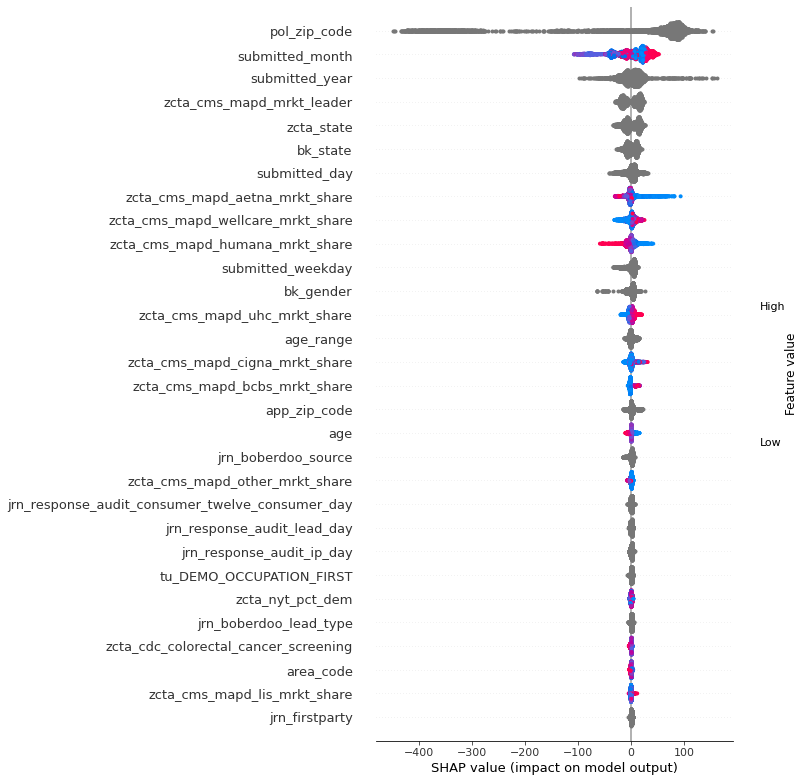

In [23]:
ts = X_test.drop(columns="LTV")
ts_lab = X_test["LTV"]

## SHAP
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(ts)

# for n in 30:
#     for t in plot_types:
shap.summary_plot(
    shap_values,
    features=ts,
    feature_names=ts.columns,
    max_display=30,
    plot_type="dot",
    # matplotlib=True,
    show=False,
)
# plt.savefig(f"shap_{t}_{n}_catboost.png", dpi=150, bbox_inches="tight")
# mlflow.log_artifact(f"shap_{t}_{n}_catboost.png")
# plt.clf()
# plt.close()

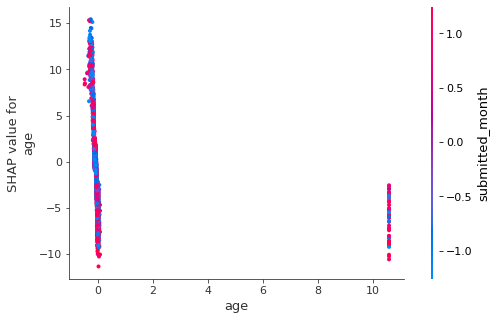

In [44]:
shap.dependence_plot('age', shap_values, ts)
# shap_values.shape

In [55]:
select_feats = X_train.columns[np.argsort(np.abs(shap_values).mean(0))][-50:]
select_feats


Index(['zcta_cdc_current_asthma', 'zcta_cms_mapd_penetration_2021',
       'zcta_usc_median_household_income', 'zcta_usc_sex_ratio',
       'zcta_usc_pct_65_74', 'zcta_cdc_high_blood_pressure',
       'zcta_cdc_obesity', 'zcta_nyt_pct_dem', 'zcta_usc_land_area_m2',
       'tu_DEMO_HOMEVALUE_DOLLARS', 'tu_DEMO_EDUCATION_YEARS',
       'zcta_cdc_annual_checkup', 'area_code', 'zcta_cdc_physical_inactivity',
       'zcta_usc_pct_65_over', 'tu_STATE', 'zcta_usc_pct_white',
       'zcta_cms_mapd_other_mrkt_share', 'tu_DEMO_CHILDREN_NO',
       'tu_STATUS_COUNT', 'zcta_cdc_diabetes', 'tu_DEMO_RESIDENT_YEARS',
       'zcta_usc_occupied_housing_units', 'app_zip_code',
       'zcta_cdc_sleep_lt_7_hours', 'zcta_usc_housing_units',
       'zcta_cms_mapd_lis_mrkt_share', 'zcta_cdc_arthritis',
       'zcta_cms_mapd_penetration_pct_change', 'zcta_cdc_health_insurance',
       'zcta_cdc_colorectal_cancer_screening', 'zcta_nyt_pct_gop',
       'jrn_boberdoo_source', 'bk_gender', 'age',
       'zcta_cms

In [56]:
X_train[select_feats]

,zcta_cdc_current_asthma,zcta_cms_mapd_penetration_2021,zcta_usc_median_household_income,zcta_usc_sex_ratio,zcta_usc_pct_65_74,zcta_cdc_high_blood_pressure,zcta_cdc_obesity,zcta_nyt_pct_dem,zcta_usc_land_area_m2,tu_DEMO_HOMEVALUE_DOLLARS,...,zcta_cms_mapd_wellcare_mrkt_share,zcta_cms_mapd_uhc_mrkt_share,zcta_cms_mapd_aetna_mrkt_share,submitted_year,zcta_cms_mapd_humana_mrkt_share,bk_state,zcta_state,zcta_cms_mapd_mrkt_leader,submitted_month,pol_zip_code
0,-1.089763,1.480370,1.108518,1.151304,1.265321,-0.189711,-0.918669,1.045784,-0.562154,-0.531180,...,-0.562512,-0.609180,0.311334,-0.770723,0.797032,FL,FL,humana,0.788142,N/A
1,-0.104328,0.175655,-0.038891,0.609719,2.214198,0.009519,-0.056434,-0.330372,1.223426,-0.531180,...,-0.361205,0.835006,-0.358056,1.056994,-0.396044,AZ,AZ,uhc,-0.804586,None
2,-0.597046,0.666098,1.137421,-0.076645,-0.375980,-0.765264,-1.284823,0.794845,-0.477731,0.805417,...,-0.748452,1.403621,-0.521340,-0.770723,-1.301449,CA,CA,uhc,1.243207,None
3,1.821749,0.646446,-1.225465,-0.280410,-0.991467,1.238103,1.786151,1.061253,-0.557206,-0.149295,...,-0.730012,-0.807713,1.260861,1.056994,0.169204,OH,OH,humana,-1.259652,None
4,-0.641838,-0.337003,0.438849,0.261175,-0.658078,-0.233984,0.038058,-0.416310,0.333009,-0.531180,...,-0.451870,0.595513,-0.454788,1.056994,0.034958,TX,TX,uhc,-1.259652,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17008,0.746729,0.461889,-0.205143,-0.216063,-0.555497,-0.521761,0.286098,-0.456987,-0.336804,0.614475,...,-0.614760,0.097252,0.032744,1.056994,-0.357183,OH,OH,uhc,-1.032119,45324
17009,0.701936,-1.053870,-0.922671,-1.170539,0.752415,1.736178,1.148333,-0.368757,0.498569,-0.531180,...,3.297658,-1.150328,-0.981014,1.056994,1.026664,MS,MS,humana,-1.032119,None
17010,0.612351,-0.597605,-0.989038,0.395230,-0.581142,1.016737,0.959350,-0.400268,0.143890,0.614475,...,-0.161436,0.529014,-0.399844,-0.770723,0.022340,SC,SC,uhc,1.015675,None
17011,1.015484,0.062016,-1.006783,-0.183890,1.419193,1.570153,1.691660,0.400102,-0.549949,-0.531180,...,-0.794553,0.764170,0.726123,-0.770723,-0.796764,IL,IL,uhc,-0.349521,62203


In [138]:
from sklearn.feature_selection import mutual_info_regression

y = ma_data["mod_LTV"]
X = ma_data.drop(columns=["mod_LTV"])


In [166]:
x = pd.get_dummies(X)
x.shape

(21047, 7734)

In [139]:
numer_X = X[numeric_columns]
mir = mutual_info_regression(X= numer_X , y= y,
#  discrete_features=True
)
mir

array([0.01158549, 0.25345448, 0.2845237 , 0.10324138, 0.17735423,
       0.02898771, 0.03118692, 0.05015583, 0.01757793, 0.04115664,
       0.02241392, 0.00452497, 0.0015903 , 0.00717776, 0.00304683,
       0.        , 0.01037589, 0.01046569, 0.00779012, 0.00116442,
       0.00642738, 0.01134993, 0.        , 0.0082303 , 0.00914579,
       0.00411636, 0.00526285, 0.        , 0.        , 0.00087692,
       0.00274498, 0.00233561, 0.00162237, 0.006815  , 0.01588131,
       0.        , 0.01062128, 0.01992563, 0.        , 0.01615028,
       0.00461905, 0.00448124, 0.00461474, 0.00848722, 0.00332899,
       0.0032698 , 0.        , 0.00518087, 0.00491297, 0.00144835,
       0.        , 0.00601685, 0.00274981, 0.00732412, 0.01071005,
       0.11818431, 0.14606171, 0.08191963, 0.06869442, 0.07661655,
       0.07280195, 0.03421806, 0.04056755, 0.02434503, 0.06762243,
       0.04104344, 0.08834944, 0.03559017, 0.03224375, 0.08025633,
       0.05462521, 0.07885452, 0.06898416, 0.06525604, 0.08887

In [153]:
np.where(mir >0.2)[0]

array([1, 2])

In [156]:
numer_X.iloc[:, np.where(mir >0.2)[0]]

,app_zip_code,submitted_month
0,32507.0,11
1,24422.0,12
2,34221.0,4
3,70737.0,3
4,78102.0,3
...,...,...
21042,79414.0,12
21043,76115.0,12
21044,77053.0,2
21045,29687.0,12


In [140]:
numer_X

,sk_owner_gender,app_zip_code,submitted_month,submitted_year,area_code,age,jrn_boberdoo_amount,jrn_date,jrn_year,jrn_month,...,tu_DEMO_HOMEOWNER_YES,tu_DEMO_HOMEOWNER_NO,tu_DEMO_HOMEVALUE_DOLLARS,tu_DEMO_RESIDENT_YEARS,tu_STATUS_COUNT,tu_STATUS_LATENCY,tu_SUB_USER_ID,tu_ACCOUNT,tu_CONTACT_SCORE,tu_CREDIT_SCORE
0,10004,32507.0,11,2021,850.0,84,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,10004,24422.0,12,2021,540.0,56,0.00,0.000000e+00,0.0,0.0,...,100.0,0.0,100000.0,12.0,17.0,0.360621,5349.0,5349.0,42.0,556.0
2,10008,34221.0,4,2022,941.0,64,13.72,1.646928e+09,2022.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,10004,70737.0,3,2022,225.0,64,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.328247,5349.0,5349.0,313.0,486.0
4,10004,78102.0,3,2022,361.0,72,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21042,10004,79414.0,12,2021,806.0,71,0.00,1.632671e+09,2021.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21043,10008,76115.0,12,2021,682.0,70,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21044,10004,77053.0,2,2022,832.0,77,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21045,10004,29687.0,12,2021,864.0,85,0.00,0.000000e+00,0.0,0.0,...,100.0,0.0,150000.0,30.0,18.0,0.355200,5349.0,5349.0,931.0,689.0


In [141]:
from sklearn.feature_selection import SelectPercentile
numer_X = X[numeric_columns]
selector = SelectPercentile(score_func= mutual_info_regression, percentile=70)
selector.fit(numer_X, y)

tr = selector.transform(numer_X)

In [142]:
(selector.get_feature_names_out())

array(['sk_owner_gender', 'app_zip_code', 'submitted_month',
       'submitted_year', 'area_code', 'age', 'jrn_boberdoo_amount',
       'jrn_date', 'jrn_year', 'jrn_month', 'jrn_day',
       'jrn_response_audit_authentic', 'jrn_response_audit_consumer_week',
       'jrn_response_audit_fields_email',
       'jrn_response_audit_fields_city',
       'jrn_response_audit_fields_state',
       'jrn_response_audit_device_week', 'jrn_response_audit_ip_hour',
       'jrn_response_audit_lead_age', 'jrn_response_audit_lead_duration',
       'jrn_response_audit_lead_five_minutes',
       'jrn_response_audit_result', 'zcta_latitude', 'zcta_longitude',
       'zcta_cdc_all_teeth_lost', 'zcta_cdc_annual_checkup',
       'zcta_cdc_arthritis', 'zcta_cdc_binge_drinking',
       'zcta_cdc_cancer_except_skin',
       'zcta_cdc_cervical_cancer_screening',
       'zcta_cdc_cholesterol_screening',
       'zcta_cdc_chronic_kidney_disease',
       'zcta_cdc_colorectal_cancer_screening', 'zcta_cdc_copd',
      

In [143]:
[f for f in numer_X.columns if f not in selector.get_feature_names_out()]

['jrn_hour',
 'jrn_response_audit_consumer_five_minutes',
 'jrn_response_audit_consumer_hour',
 'jrn_response_audit_consumer_twelve_hours',
 'jrn_response_audit_consumer_twelve_consumer_day',
 'jrn_response_audit_data_integrity',
 'jrn_response_audit_fields_f_name',
 'jrn_response_audit_fields_l_name',
 'jrn_response_audit_fields_phone1',
 'jrn_response_audit_fields_address1',
 'jrn_response_audit_device_five_minutes',
 'jrn_response_audit_device_hour',
 'jrn_response_audit_device_twelve_hours',
 'jrn_response_audit_device_day',
 'jrn_response_audit_consumer_dupe_check',
 'jrn_response_audit_ip_five_minutes',
 'jrn_response_audit_ip_twelve_hours',
 'jrn_response_audit_ip_day',
 'jrn_response_audit_ip_week',
 'jrn_response_audit_age',
 'jrn_response_audit_duration',
 'jrn_response_audit_lead_dupe_check',
 'jrn_response_audit_lead_dupe',
 'jrn_response_audit_lead_hour',
 'jrn_response_audit_lead_twelve_hours',
 'jrn_response_audit_lead_day',
 'jrn_response_audit_lead_week',
 'jrn_respons

In [144]:
pd.DataFrame(tr, columns=selector.get_feature_names_out())

,sk_owner_gender,app_zip_code,submitted_month,submitted_year,area_code,age,jrn_boberdoo_amount,jrn_date,jrn_year,jrn_month,...,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,tu_ZIP,tu_DEMO_INCOME_DOLLARS,tu_DEMO_CHILDREN_NO,tu_DEMO_EDUCATION_YEARS,tu_DEMO_RESIDENT_YEARS,tu_STATUS_LATENCY,tu_CONTACT_SCORE
0,10004.0,32507.0,11.0,2021.0,850.0,84.0,0.00,0.000000e+00,0.0,0.0,...,466.67,101.0,33689.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,10004.0,24422.0,12.0,2021.0,540.0,56.0,0.00,0.000000e+00,0.0,0.0,...,28.91,88.6,5953.0,244229614.0,85000.0,100.0,13.0,12.0,0.360621,42.0
2,10008.0,34221.0,4.0,2022.0,941.0,64.0,13.72,1.646928e+09,2022.0,3.0,...,364.29,96.5,50857.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,10004.0,70737.0,3.0,2022.0,225.0,64.0,0.00,0.000000e+00,0.0,0.0,...,319.96,100.7,44744.0,70737.0,0.0,0.0,0.0,0.0,0.328247,313.0
4,10004.0,78102.0,3.0,2022.0,361.0,72.0,0.00,0.000000e+00,0.0,0.0,...,20.73,169.3,28253.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21042,10004.0,79414.0,12.0,2021.0,806.0,71.0,0.00,1.632671e+09,2021.0,9.0,...,2167.88,92.9,17806.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
21043,10008.0,76115.0,12.0,2021.0,682.0,70.0,0.00,0.000000e+00,0.0,0.0,...,1821.00,103.0,21907.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
21044,10004.0,77053.0,2.0,2022.0,832.0,77.0,0.00,0.000000e+00,0.0,0.0,...,1069.56,102.1,31521.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
21045,10004.0,29687.0,12.0,2021.0,864.0,85.0,0.00,0.000000e+00,0.0,0.0,...,328.98,89.9,41098.0,296873739.0,100000.0,100.0,13.0,30.0,0.355200,931.0


In [157]:
X

,application_name,sk_owner_gender,app_zip_code,carrier,bk_gender,submitted_month,submitted_year,area_code,age,age_range,...,tu_DEMO_HOMEOWNER_NO,tu_DEMO_HOMEVALUE_DOLLARS,tu_DEMO_RESIDENT_YEARS,tu_DEMO_OCCUPATION_FIRST,tu_STATUS_COUNT,tu_STATUS_LATENCY,tu_SUB_USER_ID,tu_ACCOUNT,tu_CONTACT_SCORE,tu_CREDIT_SCORE
0,Wellcare Dual Access (HMO D-SNP),10004,32507.0,O65 - Wellcare,F,11,2021,850.0,84,75 to 85,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
1,HumanaChoice H5216-248 (PPO),10004,24422.0,O65 - Humana,F,12,2021,540.0,56,Less than 65,...,0.0,100000.0,12.0,N/A,17.0,0.360621,5349.0,5349.0,42.0,556.0
2,AARP Medicare Advantage Plan 2 (HMO),10008,34221.0,O65 - United Health Care,M,4,2022,941.0,64,Less than 65,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
3,Humana Gold Plus H1951-048 (HMO),10004,70737.0,O65 - Humana,F,3,2022,225.0,64,Less than 65,...,0.0,0.0,0.0,N/A,10.0,0.328247,5349.0,5349.0,313.0,486.0
4,Humana Gold Plus H0028-029 (HMO),10004,78102.0,O65 - Humana,F,3,2022,361.0,72,65 to 75,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21042,Humana Honor (PPO),10004,79414.0,O65 - Humana,F,12,2021,806.0,71,65 to 75,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
21043,AARP Medicare Advantage (HMO-POS),10008,76115.0,O65 - United Health Care,M,12,2021,682.0,70,65 to 75,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
21044,Cigna TotalCare (HMO D-SNP),10004,77053.0,O65 - Cigna,F,2,2022,832.0,77,75 to 85,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
21045,HumanaChoice H5216-154 (PPO),10004,29687.0,O65 - Humana,F,12,2021,864.0,85,More than 85,...,0.0,150000.0,30.0,professional,18.0,0.355200,5349.0,5349.0,931.0,689.0


In [158]:
## Train-Test Split
y = ma_data["mod_LTV"]
X = ma_data.drop(columns=["mod_LTV"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [159]:
model = catboost.CatBoostRegressor(
    iterations=1000, 
    depth=10, 
    learning_rate=0.01, 
    loss_function='RMSE'
)

model.fit(
    X_train, 
    y_train,
    cat_features=categorical_columns,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 372.4905840	total: 154ms	remaining: 2m 33s
1:	learn: 370.5179777	total: 234ms	remaining: 1m 56s
2:	learn: 368.5346138	total: 324ms	remaining: 1m 47s
3:	learn: 366.6359995	total: 386ms	remaining: 1m 36s
4:	learn: 364.7660792	total: 473ms	remaining: 1m 34s
5:	learn: 362.8166764	total: 533ms	remaining: 1m 28s
6:	learn: 360.9565131	total: 584ms	remaining: 1m 22s
7:	learn: 359.2476078	total: 602ms	remaining: 1m 14s
8:	learn: 357.4113987	total: 663ms	remaining: 1m 13s
9:	learn: 355.6138705	total: 737ms	remaining: 1m 12s
10:	learn: 353.9063077	total: 794ms	remaining: 1m 11s
11:	learn: 352.1853881	total: 863ms	remaining: 1m 11s
12:	learn: 350.4269072	total: 928ms	remaining: 1m 10s
13:	learn: 348.7612824	total: 986ms	remaining: 1m 9s
14:	learn: 347.0635098	total: 1.04s	remaining: 1m 8s
15:	learn: 345.3883858	total: 1.1s	remaining: 1m 7s
16:	learn: 343.7792306	total: 1.14s	remaining: 1m 6s
17:	learn: 342.3796452	total: 1.15s	remaining: 1m 2s
18:	learn: 340.7920031	total: 1.2s	remaining

In [160]:
results = pd.DataFrame()
results['true_LTV'] = y_test
y_preds = model.predict(X_test)
results['pred_LTV'] = y_preds
results.reset_index(drop=True)

,true_LTV,pred_LTV
0,706.666667,605.015658
1,0.000000,82.452062
2,0.000000,674.993948
3,682.564103,660.775631
4,691.282051,565.426810
...,...,...
4205,757.948718,630.363934
4206,834.358974,670.869402
4207,800.512821,807.798601
4208,606.666667,565.427196


In [161]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_preds)))
print("MAE: ", mean_absolute_error(y_test, y_preds))
# print("MAPE: ", mean_absolute_percentage_error(y_test, y_preds))
print("R2 Score: ", r2_score(y_test, y_preds))
mean = np.mean(y_test)
print("Mean:", mean)
# print("NRMSE: ", np.sqrt(mean_squared_error(y_test, y_preds))/mean)
# print("NMAE: ", mean_absolute_error(y_test, y_preds)/mean)



RMSE:  233.21449679623157
MAE:  152.51034085590868
R2 Score:  0.6122509326869332
Mean: 494.92161520190064


In [1]:
# ma_data.application_name.unique()
# ma_data.carrier.unique()
import boto3
boto3.resource("iam").CurrentUser().arn

'arn:aws:iam::915124832670:user/rutvik.bhende'

## SHAP analysis

In [163]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

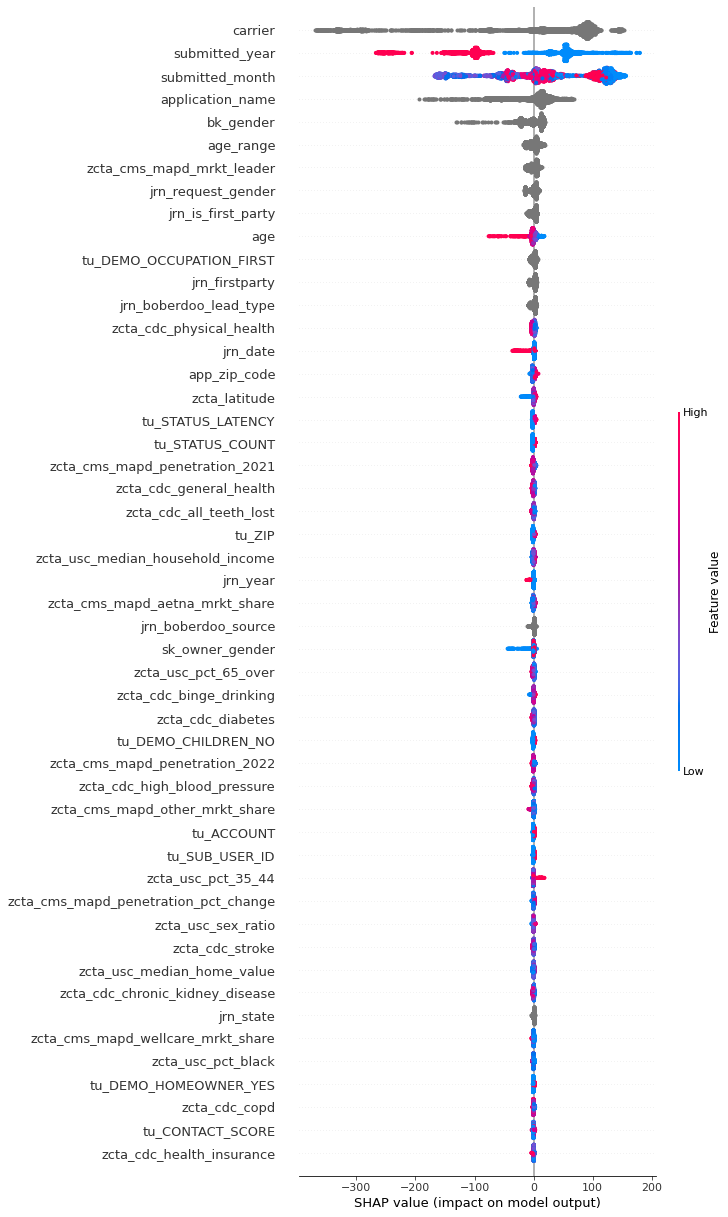

In [164]:
shap.summary_plot(
    shap_values, features=X_test, feature_names=X_test.columns, max_display=50
)

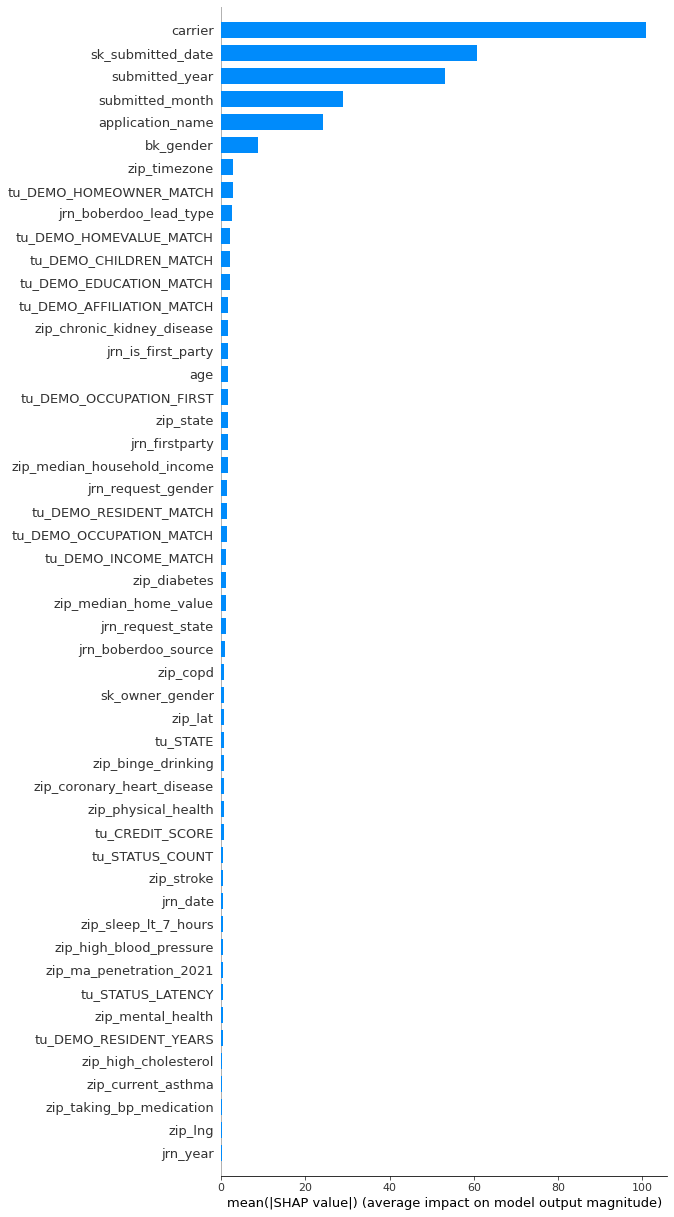

In [22]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, max_display=50, plot_type="bar")

# LGBM

In [16]:
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from lightgbm import Dataset, train
from utils.load_config_file import load_config_file

data = pd.read_csv("data/with_zcta/ma_ltv_merged.csv", low_memory=False)
config = load_config_file(config_path="config/config.ini")
## Remove unwanted features
unwanted_features = config["unwanted_features"]

## Remove any post-conversion data features; replace nulls with 0 or N/A
unwanted_features = (
    unwanted_features
    + [p for p in data.columns if "post_raw" in p.lower()]
    + [c for c in data.columns if len(data[c].fillna(0).unique()) == 1]
)
data = data.drop(columns=unwanted_features)

# replace Null values with 0 for numeric columns and N/A for categorical
categorical_columns = []
numeric_columns = []
for col in data.columns:
    if data[col].dtype in ["i", "f", int, float]:
        numeric_columns.append(col)
        data[col].fillna(0, inplace=True)
    elif data[col].dtype in ["O", "S", "a"]:
        categorical_columns.append(col)
        data[col].fillna("N/A", inplace=True)
        data[col] = pd.Series(data[col], dtype="category")
    else:
        data[col].fillna("N/A", inplace=True)
numeric_columns.remove("LTV")  # Target Variable

## Train-Test Split
y = data["LTV"]
X = data.drop(columns=["LTV"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    "n_estimators": 200,
    'learning_rate': 0.01,
    "num_leaves": 128,  
    "max_depth": 10
}
lgb_train = Dataset(X_train, y_train)
gbm = train(hyper_params, lgb_train, num_boost_round=10)

# data.head()

/Users/rutvikb/opt/anaconda3/envs/mlflow/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18363
[LightGBM] [Info] Number of data points in the train set: 16933, number of used features: 150
[LightGBM] [Info] Start training from score 436.847033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [17]:
pr = gbm.predict(X_test)
pr

array([790.78157799,  58.65406977,  60.55796873, ..., 749.08008063,
        58.51974321,  58.65406977])

In [18]:
from utils.utils import calc_regression_metrics
met = calc_regression_metrics(
    model= gbm,
    X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
met

{'test_preds_mean': 431.47407290962053,
 'MAE_train': 122.42334130898399,
 'MAE_test': 133.7739484713906,
 'RMSE_train': 183.15146634351746,
 'RMSE_test': 211.61722442690822,
 'R2_score_train': 0.8580083496492462,
 'R2_score_test': 0.8108830038328542}

In [8]:
met

app_zip_code          float64
pol_zip_code         category
carrier              category
bk_gender            category
submitted_weekday       int64
                       ...   
tu_STATUS_COUNT       float64
tu_STATUS_LATENCY     float64
tu_CONTACT_SCORE      float64
tu_CREDIT_SCORE       float64
LTV                   float64
Length: 160, dtype: object

In [ ]:
python train_lgbm.py --experiment_name rb_test1 --data_path data/with_zcta/ma_ltv_merged.csv 

# XGBOOST

In [ ]:
from xgboost import XGBRegressor
